<a href="https://colab.research.google.com/github/aarij-anwer/cyberbullying/blob/main/cyberbullying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import spacy
from spacy.util import minibatch, compounding
from spacy.training import Example
from wordcloud import WordCloud

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import random

try:
    nlp = spacy.load("en_core_web_lg")
except:
    !python -m spacy download en_core_web_lg
    nlp = spacy.load("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Read and Visualize the Data

In [ ]:
df = pd.read_csv("/content/final_hateXplain.csv")

In [ ]:
df.head()

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,NaN
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN
3,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,NaN
4,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,NaN


In [ ]:
df[["comment","label"]].head()

,comment,label
0,0 u0 lmao wow fuck you too 😂 😂,normal
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive
2,1 0 yrs <number> white women raped by niggers ...,hatespeech
3,1 2 h ago ching chong accepted your friend req...,offensive
4,1 8 th century mayhem and lawlessness had noth...,normal


In [ ]:
df["label"].unique()

array(['normal', 'offensive', 'hatespeech'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20109 entries, 0 to 20108
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             20109 non-null  object
 1   label               20109 non-null  object
 2   Race                20109 non-null  object
 3   Religion            20109 non-null  object
 4   Gender              20109 non-null  object
 5   Sexual Orientation  20109 non-null  object
 6   Miscellaneous       3533 non-null   object
dtypes: object(7)
memory usage: 1.1+ MB


## Summary of the Data

* The data has a column called 'label' which contains three unique values: 'Normal', 'Offensive' or 'Hatespeech'. We will be training the models to classify the comments as one of the three values.
* The **'comment'** column after cleaning and preprocessing will serve as the X (features)
* The **'label'** column will serve as the y (labels). It does not require cleaning.
* The dataset is mostly clean and does not have any missing values except in Miscellaneous column.


# Helper Functions

These functions will help in preprocessing the data, training and evaluating the model.

## Generate Word Clouds

4 Word Clouds are generated by this function (all comments, offensive, normal and hate speech).

In [ ]:
def generate_word_clouds(df, text_column, label_column, background_color='white'):
    # Generate word cloud for all comments
    all_comments_text = " ".join(df[text_column])
    wordcloud_all = WordCloud(width=800, height=400, background_color=background_color).generate(all_comments_text)

    # Generate word clouds for each label
    wordcloud_offensive = WordCloud(width=800, height=400, background_color=background_color).generate(
        " ".join(df[df[label_column] == "offensive"][text_column]))
    wordcloud_normal = WordCloud(width=800, height=400, background_color=background_color).generate(
        " ".join(df[df[label_column] == "normal"][text_column]))
    wordcloud_hatespeech = WordCloud(width=800, height=400, background_color=background_color).generate(
        " ".join(df[df[label_column] == "hatespeech"][text_column]))

    plt.figure(figsize=(16, 12))

    # Word cloud for all comments
    plt.subplot(2, 2, 1)
    plt.imshow(wordcloud_all, interpolation='bilinear')
    plt.title('Word Cloud of All Comments')
    plt.axis('off')

    ax = plt.gca()
    rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='black', linewidth=2, fill=False)
    ax.add_patch(rect)

    # Word cloud for offensive comments
    plt.subplot(2, 2, 2)
    plt.imshow(wordcloud_offensive, interpolation='bilinear')
    plt.title('Word Cloud for Offensive Comments')
    plt.axis('off')

    ax = plt.gca()
    rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='black', linewidth=2, fill=False)
    ax.add_patch(rect)

    # Word cloud for normal comments
    plt.subplot(2, 2, 3)
    plt.imshow(wordcloud_normal, interpolation='bilinear')
    plt.title('Word Cloud for Normal Comments')
    plt.axis('off')

    ax = plt.gca()
    rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='black', linewidth=2, fill=False)
    ax.add_patch(rect)

    # Word cloud for hatespeech comments
    plt.subplot(2, 2, 4)
    plt.imshow(wordcloud_hatespeech, interpolation='bilinear')
    plt.title('Word Cloud for Hatespeech Comments')
    plt.axis('off')

    ax = plt.gca()
    rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='black', linewidth=2, fill=False)
    ax.add_patch(rect)

    # Show the plots
    plt.tight_layout()
    plt.show()

## Unique Labels

A function to count occurences of unique values in a column (spefically the labels).

In [ ]:
def count_unique_labels(y):
  unique_values, counts = np.unique(y, return_counts=True)

  # Display the results
  for value, count in zip(unique_values, counts):
      print(f"Value: {value}, Count: {count}")

## Function to Evaluate the Model

Trains the `model` on `X_train`, then tests the `model` on the `X_test`, printing the:
* Training accuracy
* Testing accuracy
* Classification report
* Confusion matrix

In [ ]:
def print_evaluation_metrics(train_accuracy, test_accuracy, classification_report, confusion_matrix, target_names):
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report)
    print("\nConfusion Matrix:")
    print(confusion_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()


In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, target_names):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    cr = classification_report(y_test, y_test_pred, target_names=target_names)
    cm = confusion_matrix(y_test, y_test_pred)

    print_evaluation_metrics(train_accuracy, test_accuracy, cr, cm, target_names)

In [ ]:
def evaluate_pytorch_model(model, X_train_tensor, y_train, X_test_tensor, y_test, target_names, device='cpu'):
    model.to(device)
    model.eval()

    X_train_tensor = X_train_tensor.to(device)
    X_test_tensor = X_test_tensor.to(device)

    # Perform predictions on training and testing data
    with torch.no_grad():
        y_train_pred_tensor = model(X_train_tensor)
        y_test_pred_tensor = model(X_test_tensor)

    # Move to CPU before converting to NumPy
    y_train_pred = torch.argmax(y_train_pred_tensor, dim=1).cpu().numpy()
    y_test_pred = torch.argmax(y_test_pred_tensor, dim=1).cpu().numpy()

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    cr = classification_report(y_test, y_test_pred, target_names=target_names)
    cm = confusion_matrix(y_test, y_test_pred)

    print_evaluation_metrics(train_accuracy, test_accuracy, cr, cm, target_names)


## Predict Comments Function

Function to perform inference on comments to check the correctness of the model on unseen data

In [ ]:
def predict_comments(model, comments, tfidf_vectorizer, preprocess_function, label_encoder, use_pytorch=False):
    # Preprocess the comments
    comments_preprocessed = [preprocess_function(comment) for comment in comments]

    # Transform the comments using the TF-IDF vectorizer
    comments_tfidf = tfidf_vectorizer.transform(comments_preprocessed)

    if use_pytorch:
        # Convert the TF-IDF features to a PyTorch tensor
        comments_tfidf = torch.tensor(comments_tfidf.toarray(), dtype=torch.float32)

        # Ensure the model is in evaluation mode
        model.eval()

        # Make predictions using the PyTorch model
        with torch.no_grad():
            logits = model(comments_tfidf)
            predictions = torch.argmax(logits, dim=1).numpy()
    else:
        # Make predictions using the scikit-learn model
        predictions = model.predict(comments_tfidf)

    # Convert predictions back to original labels
    predicted_labels = label_encoder.inverse_transform(predictions)

    # Display predictions
    print("\nPredictions on New Data:")
    for comment, prediction in zip(comments, predicted_labels):
        print(f"Comment: {comment}\nPredicted Label: {prediction}\n")


In [ ]:
def predict_comments_spacy(model, comments, preprocess_function, label_encoder):
    predicted_labels = []
    for comment in comments:
        doc = model(comment)
        prediction = doc.cats
        print(f"---prediction--- {prediction}")
        highest_category = max(prediction, key=prediction.get)
        predicted_labels.append(highest_category)

    # Convert predictions back to original labels
    predicted_labels = label_encoder.transform(predicted_labels)

    # Display predictions
    print("\nPredictions on New Data:")
    for comment, prediction in zip(comments, label_encoder.inverse_transform(predicted_labels)):
        print(f"Comment: {comment}\nPredicted Label: {prediction}\n")

# Preprocessing the Data


## Prepocessing Steps

* The 'comment' column will be cleaned as follows:
  1. Remove stop words
  2. Remove punctuation
  3. Lemmatize the text
  4. Remove non-alphabetic characters
  5. Remove the phrase 'h ago'
* The 'Miscellaneous' column will be dropped as it has a lot of missing values.
* The cleaned comments (X) will be vectorized using TF-IDF.
* The 'label' column (y) will be encoded into numeric form using `LabelEncoder`.
* Split data into training and testing data.

In [ ]:
def preprocess_text(text):
    text = text.lower().replace('h ago', '')
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    tokens = [token for token in tokens if token.isalpha()]
    return " ".join(tokens)

In [ ]:
try:
  df = pd.read_csv("/content/cleaned_data.csv")
  print("Clean data loaded from CSV")
except:
  df['cleaned_comment'] = df['comment'].apply(preprocess_text)
  df = df.drop(columns=['Miscellaneous'])
  df.to_csv('cleaned_data.csv', index=False)
  print("Data cleaning complete")

Data cleaning complete


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5)
X = tfidf_vectorizer.fit_transform(df['cleaned_comment'])

In [ ]:
y = df['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])
df['encoded_label'] = y_encoded

In [ ]:
df.head()

,comment,label,Race,Religion,Gender,Sexual Orientation,cleaned_comment,encoded_label
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,lmao wow fuck,1
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,th floor maybe wow cnn fakenews body count go ...,2
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,yr number white woman rape nigger number negre...,0
3,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,ching chong accept friend request,2
4,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,th century mayhem lawlessness loud mouth donal...,1


In [ ]:
count_unique_labels(y_encoded)

Value: 0, Count: 6484
Value: 1, Count: 7818
Value: 2, Count: 5807


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16087, 5073), (4022, 5073), (16087,), (4022,))

In [ ]:
num_samples, num_features = X_train.shape
print(num_features)

5073


In [ ]:
num_labels = len(df["label"].unique())
print(num_labels)

3


## Visualizing the Data after Preprocessing

### Cleaned Data

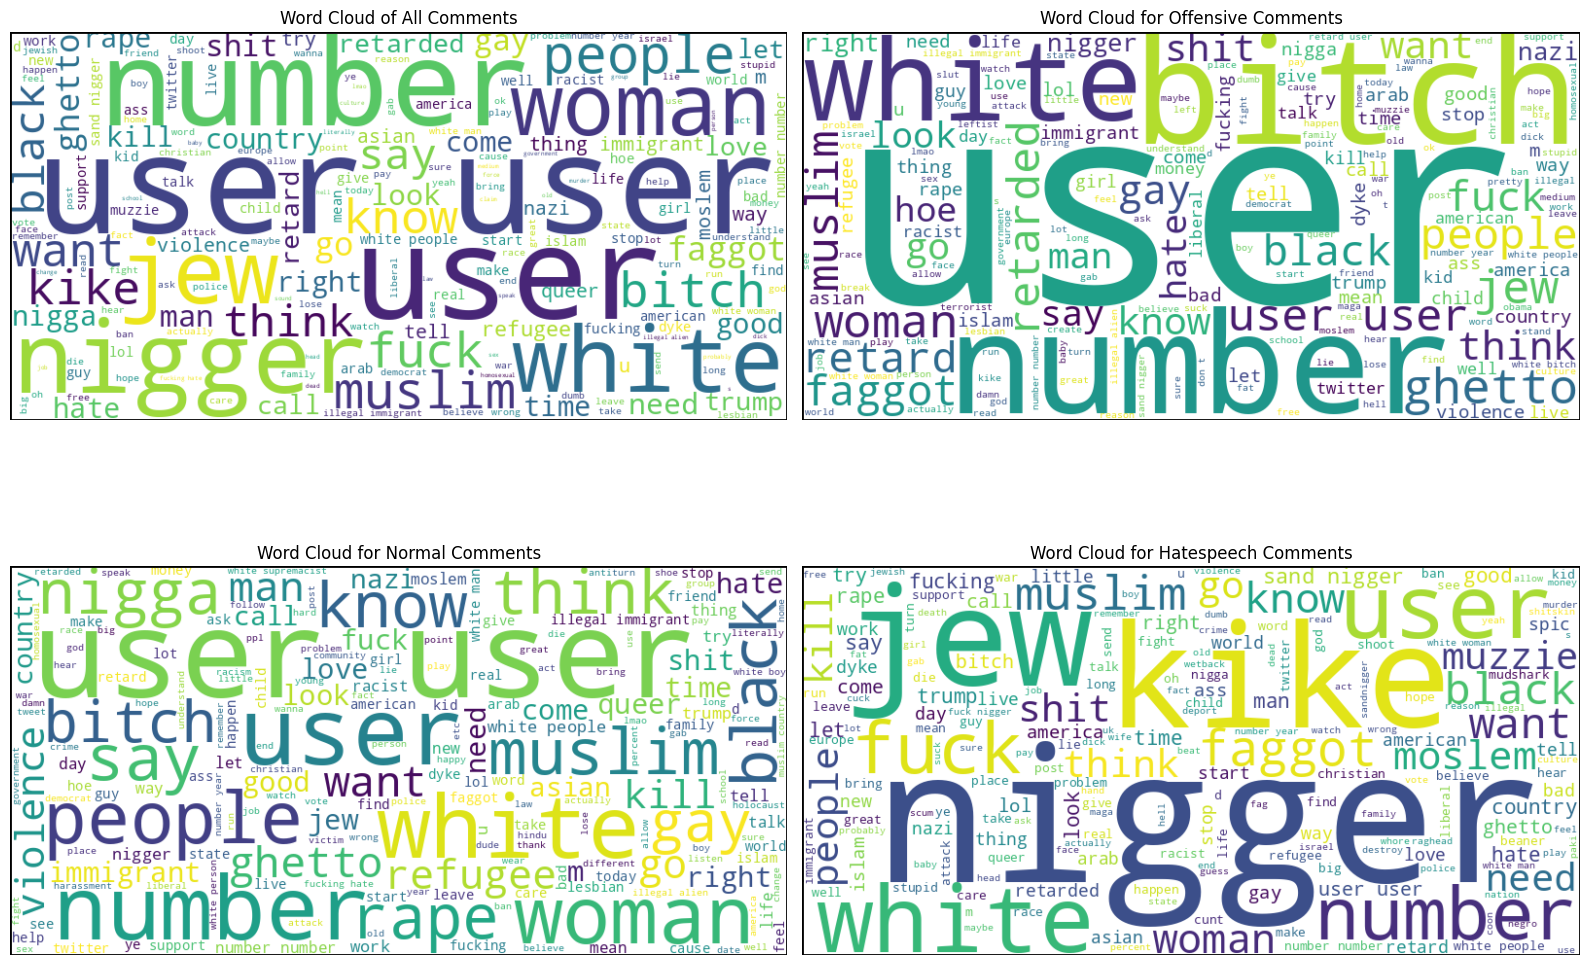

In [ ]:
generate_word_clouds(df, text_column='cleaned_comment', label_column='label')

### Unclean Data

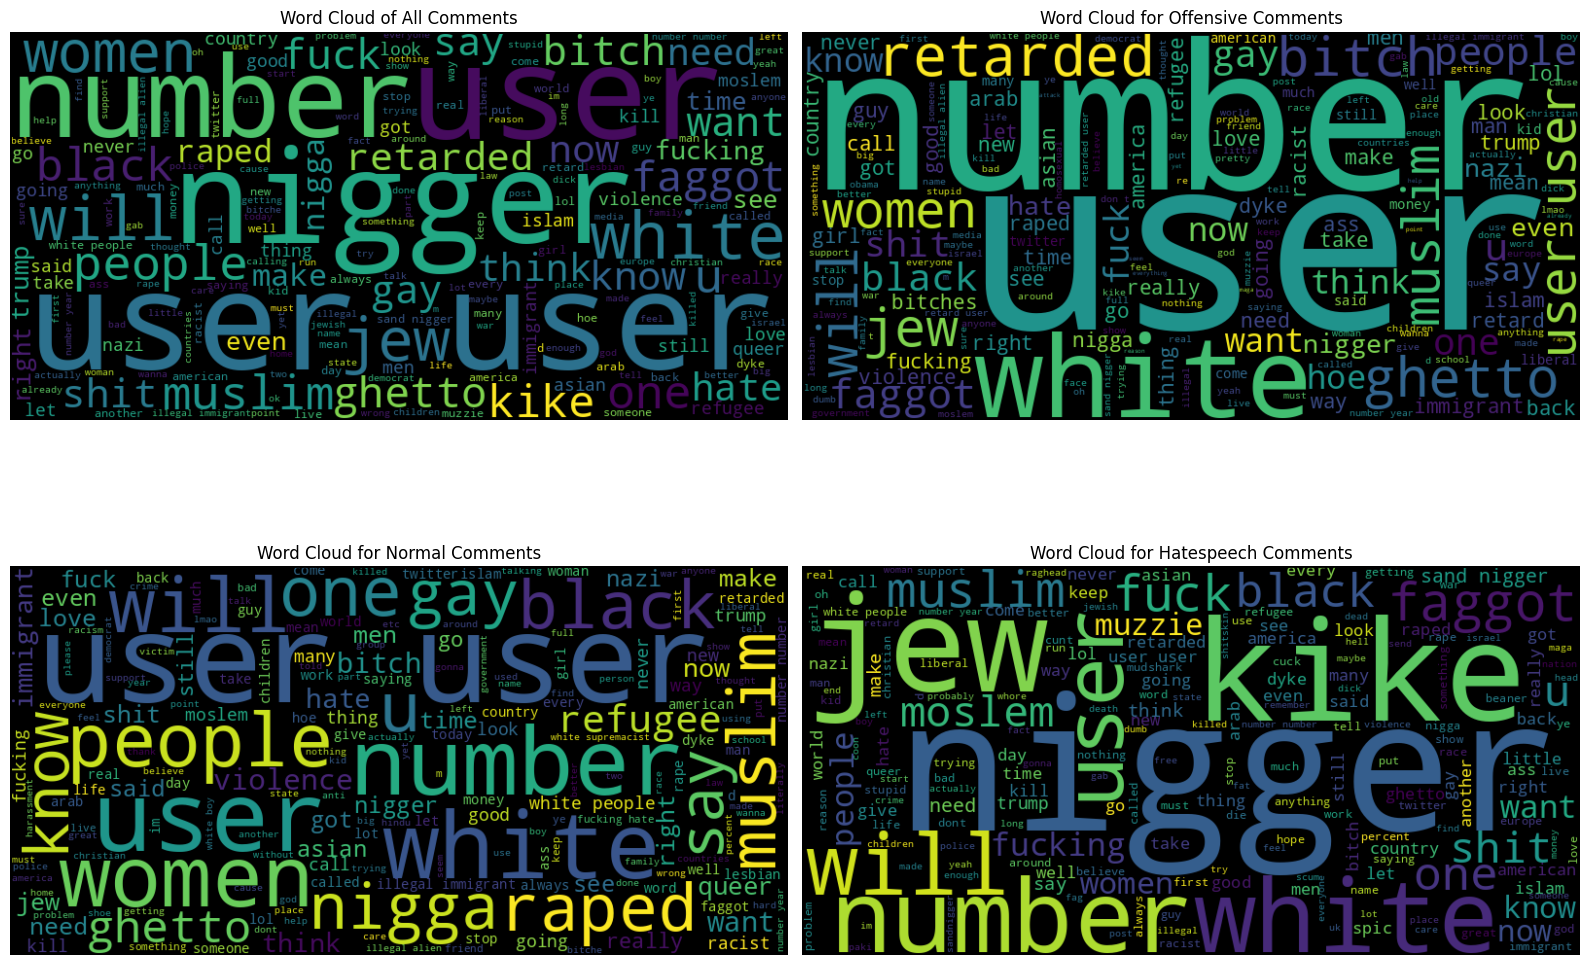

In [ ]:
generate_word_clouds(df, text_column='comment', label_column='label', background_color='black')

# Model 1: XGBoost with Default Training Set


In [ ]:
xgb_model_1 = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y.unique()), use_label_encoder=False)
xgb_model_1.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Training Accuracy: 76.21%
Testing Accuracy: 65.39%

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.77      0.68      0.72      1325
      normal       0.62      0.83      0.71      1502
   offensive       0.58      0.41      0.48      1195

    accuracy                           0.65      4022
   macro avg       0.66      0.64      0.64      4022
weighted avg       0.66      0.65      0.64      4022


Confusion Matrix:
[[ 898  243  184]
 [  86 1243  173]
 [ 186  520  489]]


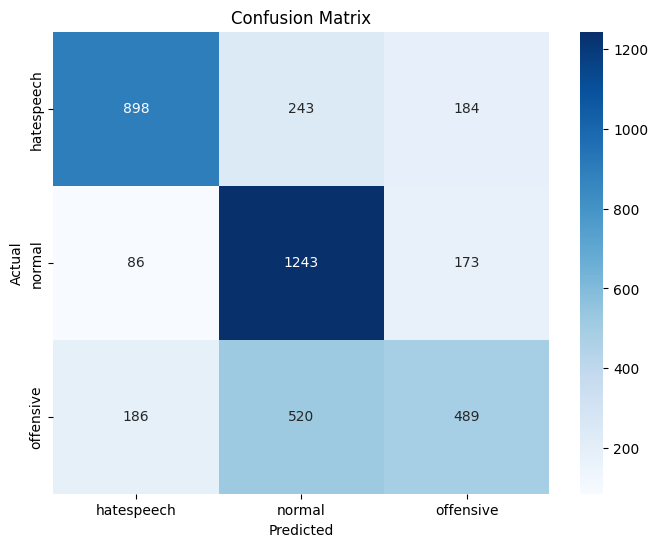

In [ ]:
evaluate_model(xgb_model_1, X_train, y_train, X_test, y_test, label_encoder.classes_)

## Run Model on Unseen Data

In [ ]:
new_comments = ["You are a good person", "You are a man with small eyes", "You are a Chinese man with small eyes", "You are a nigger"]
predict_comments(xgb_model_1, new_comments, tfidf_vectorizer, preprocess_text, label_encoder)


Predictions on New Data:
Comment: You are a good person
Predicted Label: normal

Comment: You are a man with small eyes
Predicted Label: normal

Comment: You are a Chinese man with small eyes
Predicted Label: normal

Comment: You are a nigger
Predicted Label: hatespeech



## Hyperparameter Tuning

* Exhaustive Search Over Parameter Combinations: The hyperparameter tuning is being performed using GridSearchCV, which exhaustively searches through all possible combinations of the specified hyperparameters (e.g., n_estimators, max_depth, learning_rate, subsample, colsample_bytree) to find the best combination that maximizes model performance according to the specified scoring metric (in this case, accuracy).

* Cross-Validation for Model Robustness: The tuning process involves cross-validation (cv=5), meaning that the dataset is split into 5 different subsets, and the model is trained and validated on each subset in turn.

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost classifier
xgb_model_4_grid_search = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y.unique()), use_label_encoder=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model_4_grid_search, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit GridSearchCV
xgb_model_4_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Training Accuracy: 76.21%
Testing Accuracy: 65.39%

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.77      0.68      0.72      1325
      normal       0.62      0.83      0.71      1502
   offensive       0.58      0.41      0.48      1195

    accuracy                           0.65      4022
   macro avg       0.66      0.64      0.64      4022
weighted avg       0.66      0.65      0.64      4022


Confusion Matrix:
[[ 898  243  184]
 [  86 1243  173]
 [ 186  520  489]]


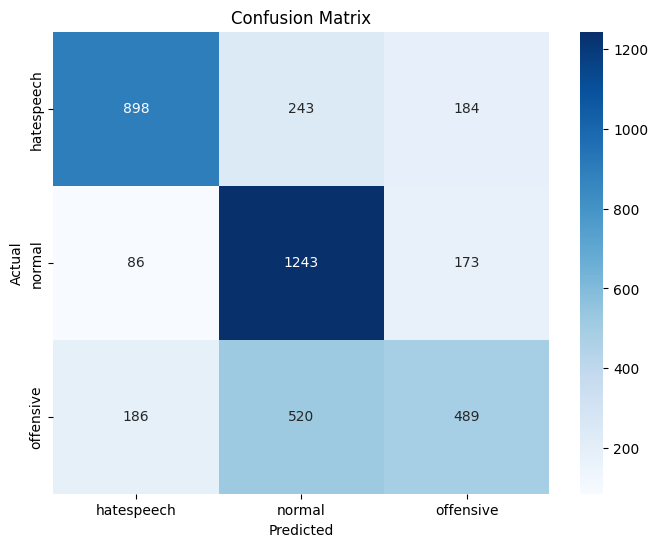

In [ ]:
evaluate_model(xgb_model_4_grid_search, X_train, y_train, X_test, y_test, label_encoder.classes_)

# Model 2: XGBoost Classifier with Balanced Training Dataset


There is a slight imbalance in the dataset from the previous run.

We fix this by using SMOTE algorithm to perform over sampling of the minority classes

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y_encoded)

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [ ]:
count_unique_labels(y_encoded)

NameError: name 'y_encoded' is not defined

In [ ]:
count_unique_labels(y_balanced)

Value: 0, Count: 7818
Value: 1, Count: 7818
Value: 2, Count: 7818


In [ ]:
xgb_model_2_balanced = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y.unique()), use_label_encoder=False)
xgb_model_2_balanced.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Training Accuracy: 77.90%
Testing Accuracy: 66.43%

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.78      0.70      0.74      1541
      normal       0.62      0.74      0.67      1565
   offensive       0.61      0.56      0.59      1585

    accuracy                           0.66      4691
   macro avg       0.67      0.66      0.66      4691
weighted avg       0.67      0.66      0.66      4691


Confusion Matrix:
[[1075  222  244]
 [  98 1154  313]
 [ 203  495  887]]


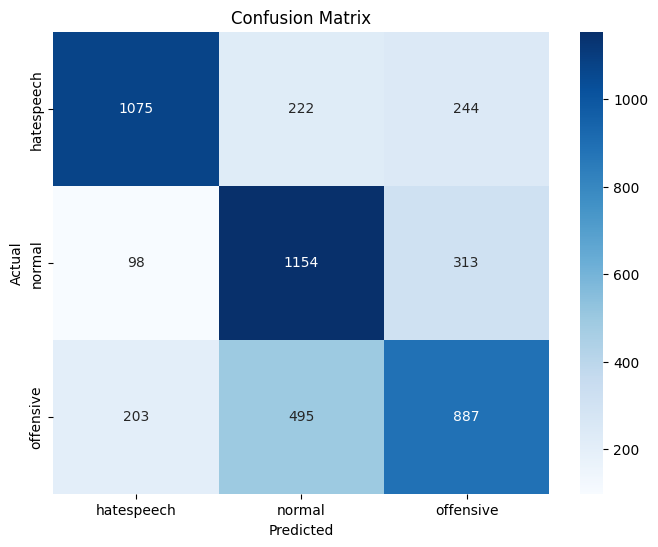

In [ ]:
evaluate_model(xgb_model_2_balanced, X_train_balanced, y_train_balanced, X_test_balanced, y_test_balanced, label_encoder.classes_)

## Run Model on Unseen Data

In [ ]:
new_comments = ["You are a good person", "You are a man with small eyes", "You are a Chinese man with small eyes", "You are a nigger"]
predict_comments(xgb_model_2_balanced, new_comments, tfidf_vectorizer, preprocess_text, label_encoder)


Predictions on New Data:
Comment: You are a good person
Predicted Label: normal

Comment: You are a man with small eyes
Predicted Label: normal

Comment: You are a Chinese man with small eyes
Predicted Label: normal

Comment: You are a nigger
Predicted Label: hatespeech



## Hyperparameter Tuning

* Model Optimization with Selected Hyperparameters: The hyperparameter tuning in this case involves manually setting specific values for key parameters such as max_depth, learning_rate, n_estimators, subsample, colsample_bytree, and regularization parameters (gamma, reg_lambda, reg_alpha).
* Handling Imbalanced Data with SMOTE: Before tuning the model, the data is balanced using SMOTE, which generates synthetic samples to balance the class distribution. This ensures that the model is not biased towards the majority class and is better equipped to handle the imbalanced nature of the dataset.

In [ ]:
xgb_model_3_balanced = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    max_depth=6,           # Maximum depth of a tree, adjust based on dataset complexity
    learning_rate=0.1,     # Step size shrinkage
    n_estimators=500,      # Number of boosting rounds (epochs)
    subsample=0.8,         # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=1,               # Minimum loss reduction required to make a further partition
    reg_lambda=1,          # L2 regularization term on weights
    reg_alpha=0,           # L1 regularization term on weights (useful for feature selection)
    scale_pos_weight=1,    # Balancing of positive and negative weights
    random_state=42
)

# Train the model
xgb_model_3_balanced.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Training Accuracy: 80.73%
Testing Accuracy: 67.38%

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.77      0.70      0.74      1541
      normal       0.63      0.75      0.68      1565
   offensive       0.63      0.57      0.60      1585

    accuracy                           0.67      4691
   macro avg       0.68      0.67      0.67      4691
weighted avg       0.68      0.67      0.67      4691


Confusion Matrix:
[[1085  214  242]
 [ 105 1167  293]
 [ 214  462  909]]


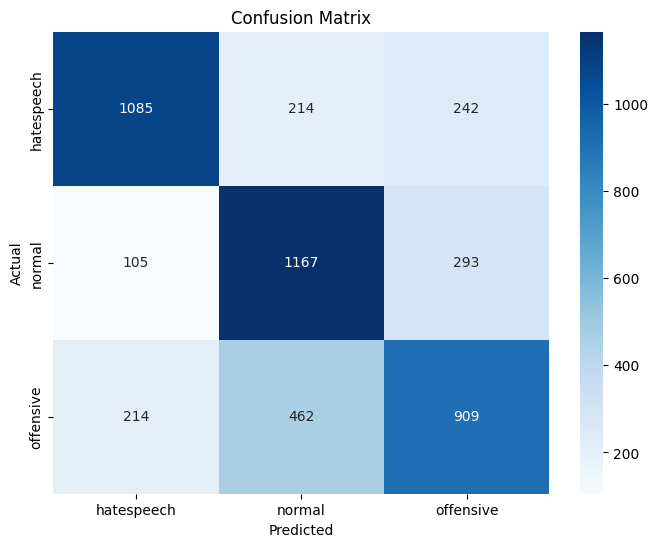

In [ ]:
evaluate_model(xgb_model_3_balanced, X_train_balanced, y_train_balanced, X_test_balanced, y_test_balanced, label_encoder.classes_)

In [ ]:
new_comments = ["You are a good person", "You are a man with small eyes", "You are a Chinese man with small eyes", "You are a nigger"]
predict_comments(xgb_model_3_balanced, new_comments, tfidf_vectorizer, preprocess_text, label_encoder)


Predictions on New Data:
Comment: You are a good person
Predicted Label: normal

Comment: You are a man with small eyes
Predicted Label: normal

Comment: You are a Chinese man with small eyes
Predicted Label: normal

Comment: You are a nigger
Predicted Label: hatespeech



In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost classifier
xgb_model_5_grid_search_balanced = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y.unique()), use_label_encoder=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model_5_grid_search_balanced, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit GridSearchCV
xgb_model_5_grid_search_balanced.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Training Accuracy: 77.90%
Testing Accuracy: 66.43%

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.78      0.70      0.74      1541
      normal       0.62      0.74      0.67      1565
   offensive       0.61      0.56      0.59      1585

    accuracy                           0.66      4691
   macro avg       0.67      0.66      0.66      4691
weighted avg       0.67      0.66      0.66      4691


Confusion Matrix:
[[1075  222  244]
 [  98 1154  313]
 [ 203  495  887]]


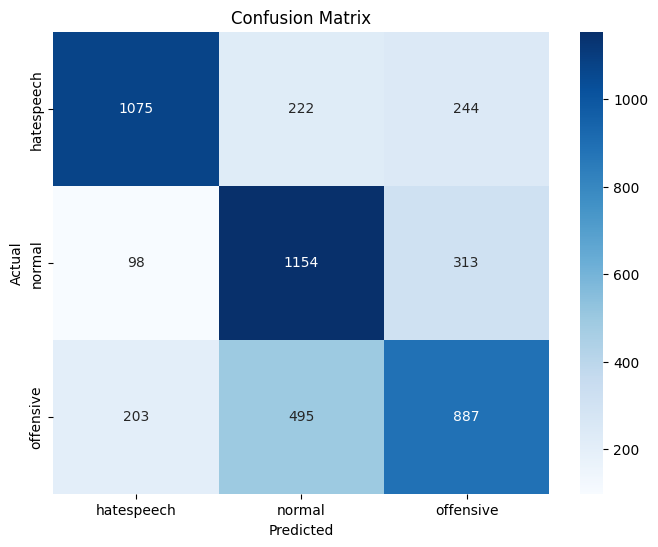

In [ ]:
evaluate_model(xgb_model_5_grid_search_balanced, X_train_balanced, y_train_balanced, X_test_balanced, y_test_balanced, label_encoder.classes_)

# Model 3 - Logistic Regression

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
clf

LogisticRegression(random_state=0)

Training Accuracy: 75.99%
Testing Accuracy: 62.90%

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.72      0.68      0.70      1325
      normal       0.61      0.77      0.68      1502
   offensive       0.55      0.39      0.46      1195

    accuracy                           0.63      4022
   macro avg       0.62      0.61      0.61      4022
weighted avg       0.63      0.63      0.62      4022


Confusion Matrix:
[[ 902  249  174]
 [ 131 1161  210]
 [ 227  501  467]]


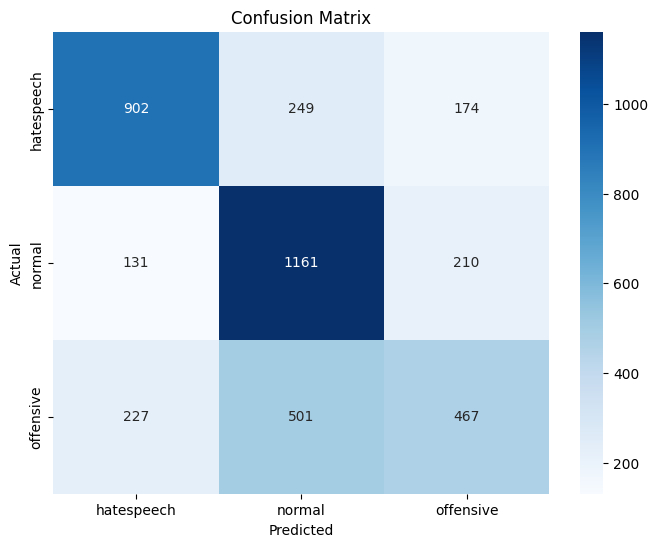

In [ ]:
evaluate_model(clf, X_train, y_train, X_test, y_test, label_encoder.classes_)

## Run Model on Unseen Data

In [ ]:
new_comments = ["You are a good person", "You are a man with small eyes", "You are a Chinese man with small eyes", "You are a nigger"]
predict_comments(clf, new_comments, tfidf_vectorizer, preprocess_text, label_encoder)


Predictions on New Data:
Comment: You are a good person
Predicted Label: normal

Comment: You are a man with small eyes
Predicted Label: normal

Comment: You are a Chinese man with small eyes
Predicted Label: offensive

Comment: You are a nigger
Predicted Label: hatespeech



## Hyperparameter Tuning

* Regularization and Complexity Control: The grid search tunes the regularization strength (C) and type of regularization (penalty) to find the best balance between underfitting and overfitting.

* Optimization Algorithm Selection: Different optimization solvers (liblinear and saga) are tested.

In [ ]:
param_grid = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0.0, 0.5, 1.0]}
]

# Set up GridSearchCV with LogisticRegression
grid_search = GridSearchCV(LogisticRegression(random_state=0), param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Training Accuracy: 69.37%
Testing Accuracy: 64.17%

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.74      0.69      0.71      1325
      normal       0.60      0.83      0.69      1502
   offensive       0.60      0.35      0.45      1195

    accuracy                           0.64      4022
   macro avg       0.65      0.62      0.62      4022
weighted avg       0.65      0.64      0.63      4022


Confusion Matrix:
[[ 912  282  131]
 [ 107 1245  150]
 [ 208  563  424]]


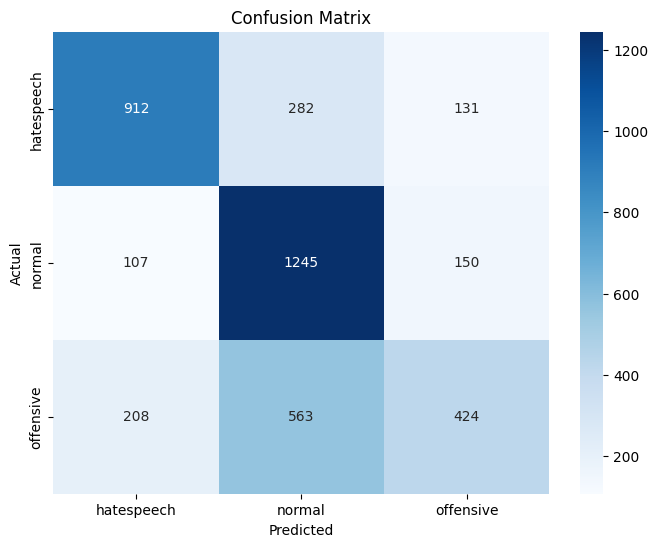

In [ ]:
evaluate_model(best_model, X_train, y_train, X_test, y_test, label_encoder.classes_)

# Model 4 - MLP Using PyTorch

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=5075, num_classes=3):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [ ]:
def train_pytorch_model(model, train_loader, criterion, optimizer, num_epochs=10):
  for epoch in range(num_epochs):
      model.train()
      for batch in train_loader:
          X_batch, y_batch = batch

          # Forward pass
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

# X_train and y_train are numpy arrays or tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

Using device cuda


In [ ]:
pytorch_model = NeuralNetwork(input_size=num_features, num_classes=num_labels).to(device)

In [ ]:
pytorch_model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5073, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the model and move it to GPU
pytorch_model = NeuralNetwork(input_size=num_features, num_classes=num_labels).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

# Train the model
train_pytorch_model(pytorch_model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.8399
Epoch [2/10], Loss: 0.6818
Epoch [3/10], Loss: 0.6103
Epoch [4/10], Loss: 0.1939
Epoch [5/10], Loss: 0.1269
Epoch [6/10], Loss: 0.0582
Epoch [7/10], Loss: 0.1033
Epoch [8/10], Loss: 0.0568
Epoch [9/10], Loss: 0.0011
Epoch [10/10], Loss: 0.0069


Training Accuracy: 99.42%
Testing Accuracy: 57.53%

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.68      0.61      0.64      1325
      normal       0.61      0.64      0.62      1502
   offensive       0.43      0.45      0.44      1195

    accuracy                           0.58      4022
   macro avg       0.57      0.57      0.57      4022
weighted avg       0.58      0.58      0.58      4022


Confusion Matrix:
[[808 200 317]
 [146 964 392]
 [232 421 542]]


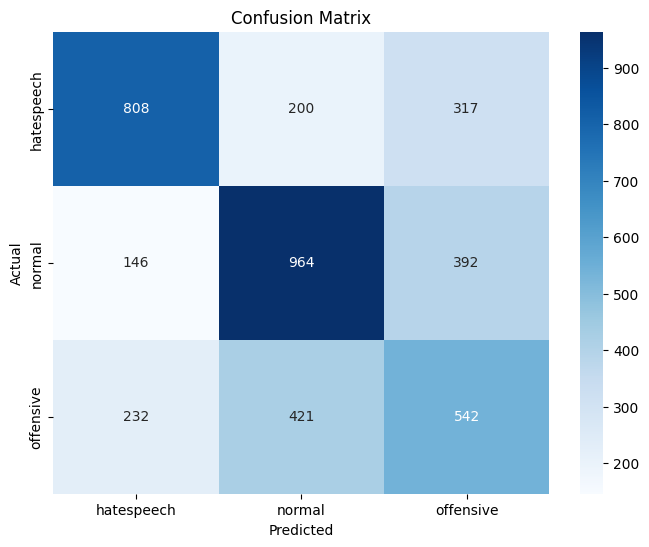

In [ ]:
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)

evaluate_pytorch_model(pytorch_model, X_train_tensor, y_train, X_test_tensor, y_test, label_encoder.classes_)

## Run Model on Unseen Data

In [ ]:
new_comments = ["You are a good person", "You are a man with small eyes", "You are a Chinese man with small eyes", "You are a nigger"]
predict_comments(pytorch_model, new_comments, tfidf_vectorizer, preprocess_text, label_encoder, use_pytorch=True)


Predictions on New Data:
Comment: You are a good person
Predicted Label: normal

Comment: You are a man with small eyes
Predicted Label: offensive

Comment: You are a Chinese man with small eyes
Predicted Label: offensive

Comment: You are a nigger
Predicted Label: hatespeech



## Hyperparameter Tuning

1. Add dropout after first two ReLU functions, add another layer.
2. Use SGD optimizer with lower learning rate, weigth decay and higher epochs.

### Add dropout and add another layer

In [ ]:
class NeuralNetworkTwo(nn.Module):
    def __init__(self, input_size=5075, num_classes=3):
        super(NeuralNetworkTwo, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, input_size // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(input_size // 2, input_size // 4),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(input_size // 4, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

pytorch_model_2 = NeuralNetworkTwo(input_size=num_features, num_classes=num_labels).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pytorch_model_2.parameters(), lr=0.001)

train_pytorch_model(pytorch_model_2, train_loader, criterion, optimizer, num_epochs=10)

Using device cuda
Epoch [1/10], Loss: 0.9765
Epoch [2/10], Loss: 0.7674
Epoch [3/10], Loss: 0.3436
Epoch [4/10], Loss: 0.3440
Epoch [5/10], Loss: 0.0120
Epoch [6/10], Loss: 0.0671
Epoch [7/10], Loss: 0.0952
Epoch [8/10], Loss: 0.0215
Epoch [9/10], Loss: 0.2382
Epoch [10/10], Loss: 0.0038


Training Accuracy: 99.33%
Testing Accuracy: 58.73%

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.64      0.66      0.65      1325
      normal       0.60      0.70      0.65      1502
   offensive       0.47      0.36      0.41      1195

    accuracy                           0.59      4022
   macro avg       0.57      0.57      0.57      4022
weighted avg       0.58      0.59      0.58      4022


Confusion Matrix:
[[ 878  228  219]
 [ 185 1058  259]
 [ 300  469  426]]


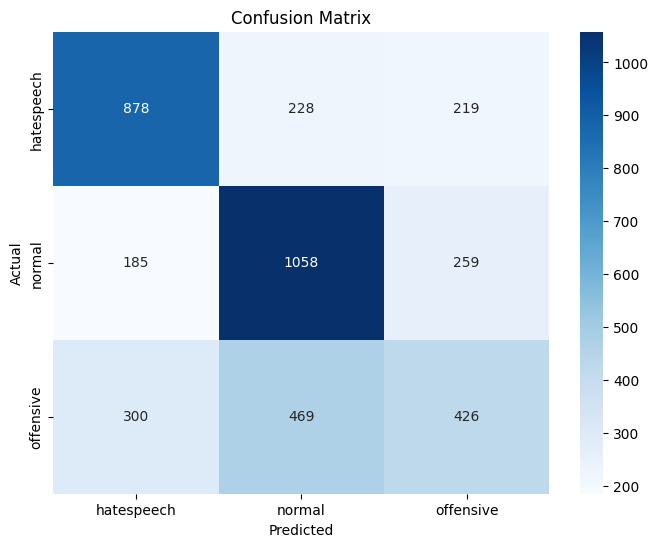

In [ ]:
evaluate_pytorch_model(pytorch_model_2, X_train_tensor, y_train, X_test_tensor, y_test, label_encoder.classes_)

In [ ]:
predict_comments(pytorch_model_2, new_comments, tfidf_vectorizer, preprocess_text, label_encoder, use_pytorch=True)


Predictions on New Data:
Comment: You are a good person
Predicted Label: normal

Comment: You are a man with small eyes
Predicted Label: offensive

Comment: You are a Chinese man with small eyes
Predicted Label: offensive

Comment: You are a nigger
Predicted Label: hatespeech



### Use SGD optimizer with lower learning rate, weigth decay and higher epochs

In [ ]:
#use SGD optimizer
pytorch_model_3 = NeuralNetworkTwo(input_size=num_features, num_classes=num_labels).to(device)

optimizer = optim.SGD(pytorch_model_3.parameters(), lr=0.001, weight_decay=0.005)

# Train the model
train_pytorch_model(pytorch_model_3, train_loader, criterion, optimizer, num_epochs=50)

Epoch [1/50], Loss: 1.0953
Epoch [2/50], Loss: 1.0786
Epoch [3/50], Loss: 1.0973
Epoch [4/50], Loss: 1.0896
Epoch [5/50], Loss: 1.0862
Epoch [6/50], Loss: 1.0756
Epoch [7/50], Loss: 1.1010
Epoch [8/50], Loss: 1.0812
Epoch [9/50], Loss: 1.1082
Epoch [10/50], Loss: 1.0968
Epoch [11/50], Loss: 1.1042
Epoch [12/50], Loss: 1.0790
Epoch [13/50], Loss: 1.0710
Epoch [14/50], Loss: 1.0448
Epoch [15/50], Loss: 1.0653
Epoch [16/50], Loss: 1.0799
Epoch [17/50], Loss: 1.1353
Epoch [18/50], Loss: 1.0472
Epoch [19/50], Loss: 1.0736
Epoch [20/50], Loss: 1.1003
Epoch [21/50], Loss: 1.0167
Epoch [22/50], Loss: 1.0898
Epoch [23/50], Loss: 1.1362
Epoch [24/50], Loss: 1.0918
Epoch [25/50], Loss: 1.1048
Epoch [26/50], Loss: 1.0648
Epoch [27/50], Loss: 1.0974
Epoch [28/50], Loss: 1.0650
Epoch [29/50], Loss: 1.1193
Epoch [30/50], Loss: 1.0511
Epoch [31/50], Loss: 1.1044
Epoch [32/50], Loss: 1.0623
Epoch [33/50], Loss: 1.0601
Epoch [34/50], Loss: 1.0688
Epoch [35/50], Loss: 1.0790
Epoch [36/50], Loss: 1.0690
E

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 39.26%
Testing Accuracy: 37.34%

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.00      0.00      0.00      1325
      normal       0.37      1.00      0.54      1502
   offensive       0.00      0.00      0.00      1195

    accuracy                           0.37      4022
   macro avg       0.12      0.33      0.18      4022
weighted avg       0.14      0.37      0.20      4022


Confusion Matrix:
[[   0 1325    0]
 [   0 1502    0]
 [   0 1195    0]]


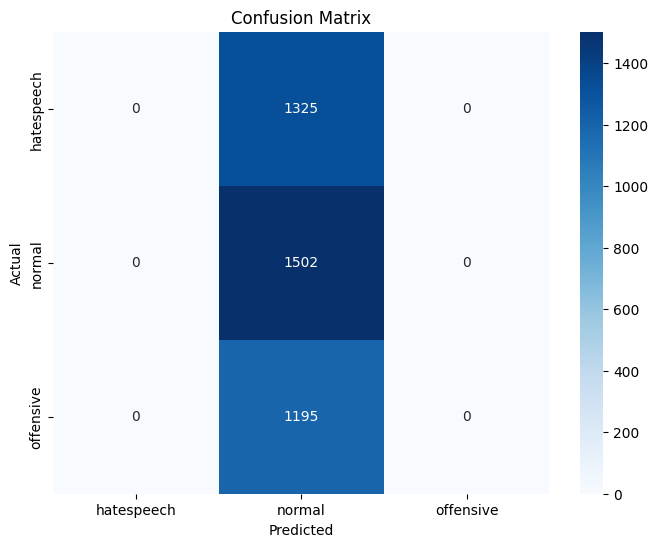


Predictions on New Data:
Comment: You are a good person
Predicted Label: normal

Comment: You are a man with small eyes
Predicted Label: normal

Comment: You are a Chinese man with small eyes
Predicted Label: normal

Comment: You are a nigger
Predicted Label: normal



In [ ]:
evaluate_pytorch_model(pytorch_model_3, X_train_tensor, y_train, X_test_tensor, y_test, label_encoder.classes_)
predict_comments(pytorch_model_3, new_comments, tfidf_vectorizer, preprocess_text, label_encoder, use_pytorch=True)

# Model 5 - SpaCy

In [ ]:
df.head()

,comment,label,Race,Religion,Gender,Sexual Orientation,cleaned_comment,encoded_label
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,lmao wow fuck,1
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,th floor maybe wow cnn fakenews body count go ...,2
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,yrs number white woman rape nigger number negr...,0
3,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,ching chong accept friend request,2
4,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,th century mayhem lawlessness loud mouthed don...,1


In [ ]:
!pip install spacy-lookups-data

In [ ]:
import spacy
import random
from spacy.util import minibatch, compounding
from spacy.training import Example
from sklearn.model_selection import train_test_split

In [ ]:
nlp = spacy.blank("en")  # Use a blank model instead of pre-trained one for text classification

if "textcat" not in nlp.pipe_names:
    textcat = nlp.add_pipe("textcat", last=True)
else:
    textcat = nlp.get_pipe("textcat")

# Define unique labels for the classification task
unique_labels = df['label'].unique()

# Add labels to the text classifier
for label in unique_labels:
    textcat.add_label(label)


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
def df_to_spacy_format(df):
    new_data = []
    for index, row in df.iterrows():
        text = row['cleaned_comment']

        categories = unique_labels
        default_cats = {category: 0 for category in categories}
        cats_dict = {"cats": default_cats}
        cats_dict["cats"][df.loc[index, 'label']] = 1

        new_data.append((text, cats_dict))
    return new_data

# Convert the DataFrame to spaCy format
data = df_to_spacy_format(df)


In [ ]:
random.shuffle(data)
split_index = int(0.7 * len(data))

train_data = data[:split_index]
test_data = data[split_index:]

print(len(train_data))
print(train_data[:2])

14076
[('feel pretty bad nork murder white guy trump charge realize kill jew mean war america found protect precious jews gay', {'cats': {'normal': 0, 'offensive': 0, 'hatespeech': 1}}), ('user kike', {'cats': {'normal': 0, 'offensive': 0, 'hatespeech': 1}})]


In [ ]:
subset_ratio = 0.7  # Use 70% of the training data as it's taking too much time
subset_size = int(len(train_data) * subset_ratio)
train_data_subset = train_data[:subset_size]

print(len(train_data_subset))

9853


In [ ]:
def nn_spacy(num_epochs, batch_size, data_train, drop=0.5):
    optimizer = nlp.initialize()
    tot_loss = []
    for epoch in range(num_epochs):
        losses = {}
        batches = minibatch(data_train, size=batch_size)
        for batch in batches:
            examples = [Example.from_dict(nlp.make_doc(text), annotations) for text, annotations in batch]
            nlp.update(examples, drop=drop, losses=losses, sgd=optimizer)
        print(f"Epoch {epoch + 1} Loss:", losses['textcat'])
        tot_loss.append(losses['textcat'])

    return tot_loss, nlp


In [ ]:
num_epochs = 4
batch_size = 32

tot_loss, trained_nlp = nn_spacy(num_epochs, batch_size, train_data_subset)

Epoch 1 Loss: 64.25221422314644
Epoch 2 Loss: 57.0246279835701
Epoch 3 Loss: 53.29787643998861
Epoch 4 Loss: 50.625469870865345


In [ ]:
def find_marked_categories(cat_dict):
    marked_categories = [category for category, value in cat_dict['cats'].items() if value == 1]
    return marked_categories[0]

def spacy_evaluate(model, data):
    correct_predictions = 0
    true_labels = []
    predicted_labels = []

    for text, true_labels_dict in data:
        doc = model(text)
        prediction = doc.cats

        highest_category = max(prediction, key=prediction.get)
        true_label = find_marked_categories(true_labels_dict)

        true_labels.append(true_label)
        predicted_labels.append(highest_category)

        if true_label == highest_category:
            correct_predictions += 1

    accuracy = correct_predictions / len(data)

    # Convert the true and predicted labels to their original encoded form
    true_labels_encoded = label_encoder.transform(true_labels)
    predicted_labels_encoded = label_encoder.transform(predicted_labels)

    return accuracy, true_labels_encoded, predicted_labels_encoded

def spacy_predict_and_evaluate(model, train_data, test_data, label_encoder):
    # Evaluate on training data
    train_accuracy, train_true_labels_encoded, train_predicted_labels_encoded = spacy_evaluate(model, train_data)
    print("Training Accuracy:", train_accuracy)

    # Evaluate on test data
    test_accuracy, test_true_labels_encoded, test_predicted_labels_encoded = spacy_evaluate(model, test_data)
    print("Testing Accuracy:", test_accuracy)

    # Generate and print the classification report for test data
    print("\nClassification Report (Test Data):")
    print(classification_report(test_true_labels_encoded, test_predicted_labels_encoded, target_names=label_encoder.classes_))

    # Generate and plot the confusion matrix for test data
    cm = confusion_matrix(test_true_labels_encoded, test_predicted_labels_encoded)
    print("\nConfusion Matrix (Test Data):")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix (Test Data)")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    return train_accuracy, test_accuracy

Training Accuracy: 0.7413985588145743
Testing Accuracy: 0.6343444389192773

Classification Report (Test Data):
              precision    recall  f1-score   support

  hatespeech       0.72      0.73      0.72      1964
      normal       0.62      0.72      0.67      2282
   offensive       0.53      0.42      0.47      1787

    accuracy                           0.63      6033
   macro avg       0.63      0.62      0.62      6033
weighted avg       0.63      0.63      0.63      6033


Confusion Matrix (Test Data):


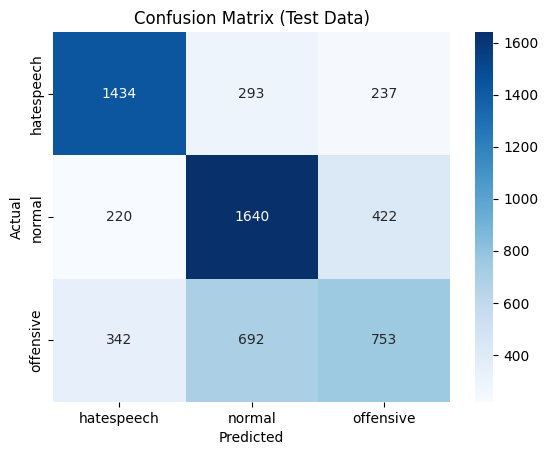

In [ ]:
train_accuracy, test_accuracy = spacy_predict_and_evaluate(trained_nlp, train_data_subset, test_data, label_encoder)

## Run Model on Unseen Data

In [ ]:
new_comments = ["You are a good person", "You are a man with small eyes", "You are a Chinese man with small eyes", "You are a nigger"]
predict_comments_spacy(trained_nlp, new_comments, preprocess_text, label_encoder)

---prediction--- {'normal': 0.6086106896400452, 'offensive': 0.3173537254333496, 'hatespeech': 0.07403557002544403}
---prediction--- {'normal': 0.9482776522636414, 'offensive': 0.0402568057179451, 'hatespeech': 0.011465505696833134}
---prediction--- {'normal': 0.859241247177124, 'offensive': 0.13181845843791962, 'hatespeech': 0.00894035492092371}
---prediction--- {'normal': 0.10218387842178345, 'offensive': 0.0183478444814682, 'hatespeech': 0.8794683218002319}

Predictions on New Data:
Comment: You are a good person
Predicted Label: normal

Comment: You are a man with small eyes
Predicted Label: normal

Comment: You are a Chinese man with small eyes
Predicted Label: normal

Comment: You are a nigger
Predicted Label: hatespeech



## Hyperparameter Tuning

1. Increase the batch size and number of epochs.
2. Lower dropout rate to 0.1 to reduce loss and improve performance.

### Increase batch size and number of epochs

Also increase training time by train on the entire training data set.

In [ ]:
num_epochs = 10
batch_size = 64

tot_loss_2, trained_nlp_2 = nn_spacy(num_epochs, batch_size, train_data)

Epoch 1 Loss: 45.53550614416599
Epoch 2 Loss: 40.49168981611729
Epoch 3 Loss: 38.34249800443649
Epoch 4 Loss: 36.69872589409351
Epoch 5 Loss: 35.308068834245205
Epoch 6 Loss: 34.931957341730595
Epoch 7 Loss: 33.78715579211712
Epoch 8 Loss: 32.94101978093386
Epoch 9 Loss: 32.44744822382927
Epoch 10 Loss: 31.49984383583069


Training Accuracy: 0.9643364592213697
Testing Accuracy: 0.6006961710591745

Classification Report (Test Data):
              precision    recall  f1-score   support

  hatespeech       0.68      0.70      0.69      1964
      normal       0.61      0.68      0.64      2282
   offensive       0.48      0.39      0.43      1787

    accuracy                           0.60      6033
   macro avg       0.59      0.59      0.59      6033
weighted avg       0.59      0.60      0.60      6033


Confusion Matrix (Test Data):


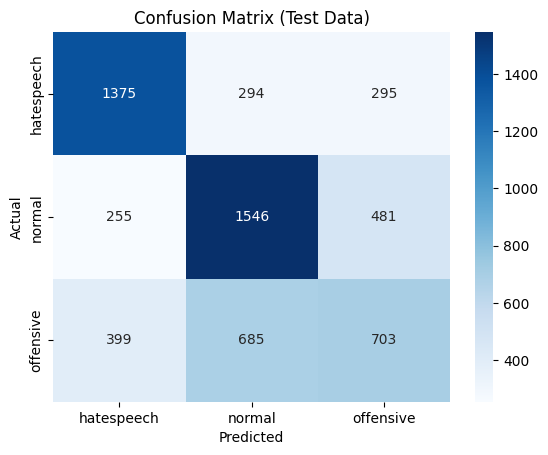

In [ ]:
train_accuracy, test_accuracy = spacy_predict_and_evaluate(trained_nlp_2, train_data, test_data, label_encoder)

In [ ]:
predict_comments_spacy(trained_nlp_2, new_comments, preprocess_text, label_encoder)

---prediction--- {'normal': 0.6086106896400452, 'offensive': 0.3173537254333496, 'hatespeech': 0.07403557002544403}
---prediction--- {'normal': 0.9482776522636414, 'offensive': 0.0402568057179451, 'hatespeech': 0.011465505696833134}
---prediction--- {'normal': 0.859241247177124, 'offensive': 0.13181845843791962, 'hatespeech': 0.00894035492092371}
---prediction--- {'normal': 0.10218387842178345, 'offensive': 0.0183478444814682, 'hatespeech': 0.8794683218002319}

Predictions on New Data:
Comment: You are a good person
Predicted Label: normal

Comment: You are a man with small eyes
Predicted Label: normal

Comment: You are a Chinese man with small eyes
Predicted Label: normal

Comment: You are a nigger
Predicted Label: hatespeech



### Lower Dropout Rate to 0.1

In [ ]:
tot_loss_3, trained_nlp_3 = nn_spacy(num_epochs, batch_size, train_data, drop=0.1)

Epoch 1 Loss: 39.47313877940178
Epoch 2 Loss: 33.604131765663624
Epoch 3 Loss: 29.372672475874424
Epoch 4 Loss: 25.505988370627165
Epoch 5 Loss: 21.598392982035875
Epoch 6 Loss: 18.177156876772642
Epoch 7 Loss: 15.765280600637197
Epoch 8 Loss: 13.903702434152365
Epoch 9 Loss: 12.30197824537754
Epoch 10 Loss: 11.09002735465765


Training Accuracy: 0.9643364592213697
Testing Accuracy: 0.6006961710591745

Classification Report (Test Data):
              precision    recall  f1-score   support

  hatespeech       0.68      0.70      0.69      1964
      normal       0.61      0.68      0.64      2282
   offensive       0.48      0.39      0.43      1787

    accuracy                           0.60      6033
   macro avg       0.59      0.59      0.59      6033
weighted avg       0.59      0.60      0.60      6033


Confusion Matrix (Test Data):


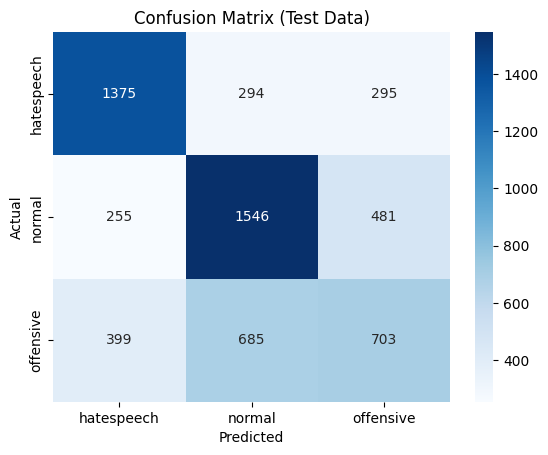

In [ ]:
train_accuracy, test_accuracy = spacy_predict_and_evaluate(trained_nlp_3, train_data, test_data, label_encoder)

In [ ]:
predict_comments_spacy(trained_nlp_3, new_comments, preprocess_text, label_encoder)

---prediction--- {'normal': 0.6086106896400452, 'offensive': 0.3173537254333496, 'hatespeech': 0.07403557002544403}
---prediction--- {'normal': 0.9482776522636414, 'offensive': 0.0402568057179451, 'hatespeech': 0.011465505696833134}
---prediction--- {'normal': 0.859241247177124, 'offensive': 0.13181845843791962, 'hatespeech': 0.00894035492092371}
---prediction--- {'normal': 0.10218387842178345, 'offensive': 0.0183478444814682, 'hatespeech': 0.8794683218002319}

Predictions on New Data:
Comment: You are a good person
Predicted Label: normal

Comment: You are a man with small eyes
Predicted Label: normal

Comment: You are a Chinese man with small eyes
Predicted Label: normal

Comment: You are a nigger
Predicted Label: hatespeech

